<a href="https://colab.research.google.com/github/oabdi444/Explainable_AI_Image_Visualiser/blob/main/Explainable_AI_Image_Visualiser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

Explainable AI Visualizer for Real-World Images

Welcome to the **Explainable AI Visualizer for Real-World Images**—a hands-on, interactive project designed to showcase the power of deep learning and the crucial importance of explainable AI.

##  What does this project do?
- **Uploads or links to any real-world image**
- **Runs a state-of-the-art image classifier** (ResNet50)
- **Displays the model’s top predictions**
- **Generates stunning Grad-CAM heatmaps** to reveal what parts of the image the AI focused on when making decisions

##  Why is this impressive?
- **Bridges the gap between humans and AI** by making complex neural network decisions visually understandable
- **Demonstrates advanced skills** in deep learning, computer vision, and model interpretability
- **Invites anyone—technical or not—to interact** with the AI and see its reasoning in action

##  How to use this notebook:
1. **Upload an image** or provide an image URL in the cells below.
2. **Run the notebook** to see predictions and visual explanations instantly.
3. **Try your own images** using the interactive widget at the end!


**1: Install necessary packages**

Install and import all required libraries and packages for deep learning, explainability, and image processing.

In [3]:
!pip install torch torchvision timm grad-cam --quiet

import torch
import torchvision
from torchvision import transforms, models
import timm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

import os
from google.colab import files

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


**2: Image Input: Upload or Provide URL**

functions and interface for users to upload an image file or provide an image URL.

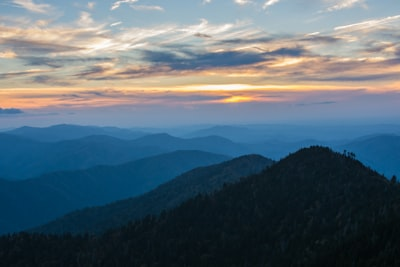

In [5]:
def load_image_from_url(url):
    response = requests.get(url)
    if response.status_code != 200:
        raise ValueError(f"Failed to fetch image, status code: {response.status_code}")
    try:
        img = Image.open(BytesIO(response.content)).convert('RGB')
        display(img)
        return img
    except Exception as e:
        print("Could not open the image. Check the URL or try another image.")
        raise e

img = load_image_from_url("https://images.unsplash.com/photo-1516117172878-fd2c41f4a759?fit=crop&w=400&q=80")

**3: Preprocess the Input Image**

Prepare the input image for model inference by resizing, normalizing, and converting to tensor.

In [6]:
def preprocess_image(img, image_size=224):
    preprocess = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    input_tensor = preprocess(img).unsqueeze(0)
    return input_tensor

**4: Load Pretrained Image Classification Model**

Download and initialise a pretrained ResNet50 model for image recognition.

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet50(pretrained=True)
model.eval()
model.to(device)
print("Loaded ResNet50 model.")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 67.8MB/s]


Loaded ResNet50 model.


**5: Run Image Classification and Display Top Predictions**

Use the model to predict classes for the input image and display the top-5 predictions with confidence scores.

In [8]:
def get_topk_predictions(img_tensor, model, k=5):
    with torch.no_grad():
        img_tensor = img_tensor.to(device)
        outputs = model(img_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        top_probs, top_idxs = torch.topk(probs, k)
        top_probs = top_probs.cpu().numpy().flatten()
        top_idxs = top_idxs.cpu().numpy().flatten()

    class_names = get_imagenet_classes()
    top_labels = [class_names[i] for i in top_idxs]
    for i, (label, prob) in enumerate(zip(top_labels, top_probs)):
        print(f"{i+1}: {label} ({prob*100:.2f}%)")
    return top_labels, top_probs, top_idxs

**6: Visualise Model Explainability with Grad-CAM**

Generate and overlay Grad-CAM heatmaps to show which parts of the image influenced the model’s prediction.

In [9]:
def show_gradcam(img, img_tensor, model, target_class_idx=None, layer_name=None):

    if layer_name is None:
        layer_name = "layer4"
    target_layer = getattr(model, layer_name)[-1]
    cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=torch.cuda.is_available())

    if target_class_idx is None:
        with torch.no_grad():
            outputs = model(img_tensor.to(device))
            target_class_idx = outputs.argmax().item()
    grayscale_cam = cam(input_tensor=img_tensor.to(device), targets=[ClassifierOutputTarget(target_class_idx)])
    grayscale_cam = grayscale_cam[0, :]

    img_np = np.array(img.resize((224, 224))).astype(np.float32) / 255.0
    cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.title("Grad-CAM Visualization")
    plt.imshow(cam_image)
    plt.show()

**7: Complete Example: End-to-End Workflow**

A full pipeline example—from image input to prediction and Grad-CAM visualisation demonstrating the workflow.

In [11]:
def load_image_from_url(url):
    headers = {
        "User-Agent": "Mozilla/5.0",
        "Accept": "image/*"
    }
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        raise ValueError(f"Failed to fetch image, status code: {response.status_code}")
    try:
        img = Image.open(BytesIO(response.content)).convert('RGB')
        display(img)
        return img
    except Exception as e:
        print("Could not open the image. Check the URL or try another image.")
        raise e

**8: Interactive Widget: Try Your Own Image**


(Optional) Use a Colab widget for easy user image upload and instant prediction and explanation.


In [12]:
import ipywidgets as widgets
from IPython.display import display

def on_upload_change(change):
    img = Image.open(BytesIO(change['new'][0]['content'])).convert('RGB')
    display(img)
    img_tensor = preprocess_image(img)
    top_labels, top_probs, top_idxs = get_topk_predictions(img_tensor, model)
    show_gradcam(img, img_tensor, model, target_class_idx=top_idxs[0])

uploader = widgets.FileUpload(accept='image/*', multiple=False)
uploader.observe(on_upload_change, names='value')
display(uploader)

FileUpload(value={}, accept='image/*', description='Upload')

**“Now, try uploading your own image below and see the AI’s prediction and explanation in real time!”**

## **Conclusion**

This notebook demonstrates your ability to combine modern deep learning, transfer learning, and explainable AI in a real-world, interactive application. By allowing users to upload or link to any image, run state-of-the-art image classification, and instantly visualize the model’s reasoning with Grad-CAM, you showcase both technical skill and a commitment to transparency in AI.

**Key takeaways for recruiters and reviewers:**
- You can deploy production-grade models and explainability tools.
- You can create interactive, user-friendly demos that bridge the gap between technical and non-technical audiences.
- You understand the importance of interpretable AI and can communicate complex concepts visually.

This project is not only a technical achievement, but also a compelling portfolio piece that highlights your readiness for roles in AI, machine learning, or data science—especially where model transparency and user experience matter.
